## Imports

In [1]:
import os
import shutil
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm # loading bar
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import librosa

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, r2_score, f1_score
from imblearn.under_sampling import RandomUnderSampler

import xgboost as xgb

from imblearn.over_sampling import RandomOverSampler

In [2]:
# Check if running on Kaggle
kaggle = ('KAGGLE_KERNEL_RUN_TYPE' in os.environ)
if kaggle:
    # Code specific to Kaggle
    print("Running on Kaggle!")
else:
    print("Not running on Kaggle.")

Running on Kaggle!


In [3]:
def extract_numbers(filename):
    filename = filename.split('.')[0] # remove extension

    split = filename.split('_')

    if len(split) > 1:
        return split[1]
    elif len(split) == 1:
        return split[0]

In [4]:
if kaggle:
    DATA_DIR = '../input/birdclef-2024/'
    OUTPUT_DIR = '/kaggle/working/'
    shutil.copy('../input/features/extracted_features.pickle', 'extracted_features.pickle')
else: # local work
    DATA_DIR = "../../data/raw/" 
    OUTPUT_DIR = "../../data/processed/"

TRAIN_AUDIO_DIR = os.path.join(DATA_DIR, "train_audio/")

train_csv_path = os.path.join(DATA_DIR, "train_metadata.csv")

# Testing
TEST_AUDIO_DIR = os.path.join(DATA_DIR,"test_soundscapes/")

# Load list of audio files by parsing the test_soundscape folder
test_file_list = sorted(os.listdir(TEST_AUDIO_DIR))
test_file_list = [file for file in test_file_list if file.endswith('.ogg')]  # Filter only ogg files

if len(test_file_list) == 0:   # replace test dir by unlabeled dir for testing
    TEST_AUDIO_DIR = os.path.join(DATA_DIR, "unlabeled_soundscapes/")
    test_file_list = sorted(os.listdir(TEST_AUDIO_DIR))
    test_file_list = [file for file in test_file_list if file.endswith('.ogg')]  # Filter only ogg files
    test_file_list = test_file_list[:5]  # Take only 5 elements to speed up debugging

test_number_list = [extract_numbers(file) for file in test_file_list]

print(f'Directory used for testing: {TEST_AUDIO_DIR}')
print(f'Number of test files: {len(test_file_list)}')

Directory used for testing: ../input/birdclef-2024/unlabeled_soundscapes/
Number of test files: 5


In [5]:
SAMPLE_RATE = 32000

In [6]:
NUM_CLASSES_TO_KEEP = 40

## Data collection

In [7]:
data = pd.read_csv(train_csv_path)

# Add complete filepath
data['filepath'] = data.apply(lambda row: os.path.join(TRAIN_AUDIO_DIR, row['filename']), axis=1)

# # Filter out large files
# data['filesize'] = data.apply(lambda row: os.path.getsize(row['filepath']), axis=1)

In [8]:
X_files = data['filepath'].values.reshape(-1, 1)
y = data['primary_label'].values

In [9]:
list_species = sorted(data.primary_label.unique())

In [10]:
num_classes = len(list_species)

## Downsampling

In [11]:
def undersample_keep_minority(X, y, threshold, num_classes_to_keep):
    # Identify minority classes
    class_counts = {label: np.sum(y == label) for label in np.unique(y)}
    minority_classes = [label for label, count in class_counts.items() if count < threshold]
    
    # Determine majority classes
    majority_classes = [label for label, count in class_counts.items() if label not in minority_classes]
    
    # Randomly select minority and majority classes to keep
    num_minority_classes_to_keep = num_classes_to_keep // 2
    num_majority_classes_to_keep = num_classes_to_keep - num_minority_classes_to_keep
    
    minority_classes_to_keep = np.random.choice(minority_classes, size=num_minority_classes_to_keep, replace=False)
    majority_classes_to_keep = np.random.choice(majority_classes, size=num_majority_classes_to_keep, replace=False)
    
    # Identify instances of selected minority and majority classes
    minority_indices_to_keep = [idx for idx, label in enumerate(y) if label in minority_classes_to_keep]
    majority_indices_to_keep = [idx for idx, label in enumerate(y) if label in majority_classes_to_keep]
    
    # Randomly undersample majority classes
    undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    X_majority, y_majority = undersampler.fit_resample(X[majority_indices_to_keep], y[majority_indices_to_keep])
    
    # Filter instances of minority classes to keep
    X_minority_to_keep = X[minority_indices_to_keep]
    y_minority_to_keep = y[minority_indices_to_keep]
    
    # Combine minority instances to keep and undersampled majority instances
    X_balanced = np.concatenate((X_minority_to_keep, X_majority), axis=0)
    y_balanced = np.concatenate((y_minority_to_keep, y_majority), axis=0)
    
    return X_balanced, y_balanced


In [12]:
# def undersample_keep_minority(X, y, threshold):
#     # Identify minority classes
#     minority_classes = [label for label in np.unique(y) if np.sum(y == label) < threshold]
    
#     # Determine majority classes
#     majority_classes = [label for label in np.unique(y) if label not in minority_classes]
    
#     # Identify minority instances meeting the threshold
#     minority_indices = [idx for idx, label in enumerate(y) if label in minority_classes]
    
#     # Randomly undersample majority classes
#     majority_indices = [idx for idx, label in enumerate(y) if label in majority_classes]
#     undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
#     X_majority, y_majority = undersampler.fit_resample(X[majority_indices], y[majority_indices])
    
#     # Combine minority instances and undersampled majority instances
#     X_balanced = np.concatenate((X[minority_indices], X_majority), axis=0)
#     y_balanced = np.concatenate((y[minority_indices], y_majority), axis=0)
    
#     return X_balanced, y_balanced


In [13]:
X_files_undersampled, y_undersampled = undersample_keep_minority(X_files, y, threshold=30, num_classes_to_keep=NUM_CLASSES_TO_KEEP)
X_files_undersampled = X_files_undersampled[:,0]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


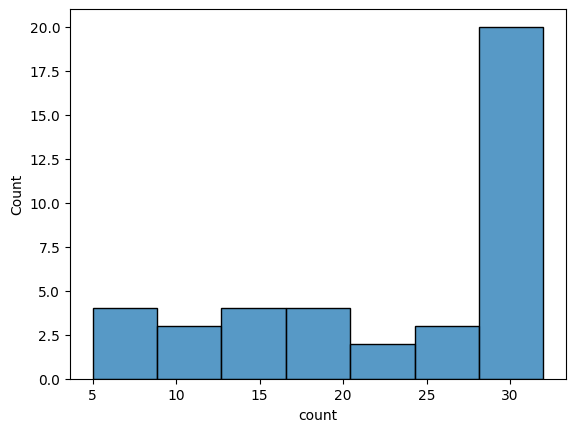

In [14]:
sns.histplot(pd.Series(y_undersampled).value_counts(), bins='rice');

## Features

In [15]:
def extract_features(audio_data, sample_rate=SAMPLE_RATE, max_length=3000):
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
    
    # Pad or truncate mfccs to ensure a fixed length
    if mfccs.shape[1] < max_length:
        pad_width = max_length - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    elif mfccs.shape[1] > max_length:
        mfccs = mfccs[:, :max_length]
    
    return mfccs

In [16]:
def load_data_and_extract_features(X_files, sample_rate=SAMPLE_RATE):
    features_list = []

    for filepath in tqdm(X_files, desc='Processing files', total=len(X_files)):
        # Process data with tqdm
        audio_data, _ = librosa.load(filepath, sr=sample_rate)
        features = extract_features(audio_data, sample_rate=sample_rate)
        features_list.append(features)

    X = np.array(features_list)

    return X

In [17]:
X = load_data_and_extract_features(X_files_undersampled)

Processing files: 100%|██████████| 948/948 [02:24<00:00,  6.55it/s]


## Label Encoding

In [18]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_undersampled)

## Train test split and Balancing

In [19]:
# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [20]:
# Rebalance after train test split!!

X_train_flatten = X_train.reshape(X_train.shape[0], -1) # flatten 2 last dimensions because over sampling requires 2D array, not 3D

ros = RandomOverSampler(random_state=42)
X_train_flatten_oversampled, y_train_oversampled = ros.fit_resample(X_train_flatten, y_train)

X_train_oversampled = X_train_flatten_oversampled.reshape(-1, *X_train.shape[1:])

In [21]:
X_train_oversampled.shape

(840, 40, 3000)

In [22]:
y_train_oversampled.shape

(840,)

## Model Training

In [23]:
def evaluate_model(model, X, y_true, prefix=''):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['f1'] = f1_score(y_true, y_pred, average='macro')
    metrics['roc_auc'] = roc_auc_score(y_true, y_pred_proba, average='macro', multi_class='ovr')
    
    for key, value in metrics.items():
        print(f'{prefix} {key} : {value:.2%}'.strip())
    
    return metrics

In [24]:
# Function used later to write proba to df
def proba_df(y_pred_proba):
    y_pred_proba_df = pd.DataFrame(y_pred_proba, columns=label_encoder.classes_)
    results = pd.DataFrame({'row_id': row_id_list}) 
    results = pd.concat([results,  y_pred_proba_df], axis=1)

    # Reorder the columns to have 'row_id' first, followed by list_species
    columns_order = ['row_id'] + list_species
    results = results.reindex(columns=columns_order).fillna(0)
    
    return results

In [25]:
# Adding number of channels (1)
X_train_oversampled = np.expand_dims(X_train_oversampled, -1)
X_val = np.expand_dims(X_val, -1)

In [26]:
from tensorflow.keras.utils import to_categorical

y_train_oversampled_cat = to_categorical(y_train_oversampled)
y_val_cat = to_categorical(y_val)

2024-04-17 14:56:59.270542: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 14:56:59.270668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 14:56:59.523081: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define CNN architecture
def create_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [29]:
model = create_model(input_shape=X_train_oversampled.shape[1:], num_classes=NUM_CLASSES_TO_KEEP)
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 2998, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 1499, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 1497, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 748, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 746, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 373, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 143232)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    36,667,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 40)             │        10,280 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,836,392 (140.52 MB)

 Trainable params: 36,836,392 (140.52 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Now, you can include the early stopping callback in your model.fit() call
history = model.fit(X_train_oversampled, y_train_oversampled_cat, batch_size=32, epochs=100, validation_data=(X_val, y_val_cat), callbacks=[early_stopping])

Epoch 1/100
 1/27 ━━━━━━━━━━━━━━━━━━━━ 7:07 16s/step - accuracy: 0.0312 - loss: 5.9200

I0000 00:00:1713366104.065578      96 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713366104.086902      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.0628 - loss: 19.9778

W0000 00:00:1713366112.707832      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 492ms/step - accuracy: 0.0641 - loss: 19.6186 - val_accuracy: 0.0461 - val_loss: 4.1254
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.2219 - loss: 3.5267 - val_accuracy: 0.0395 - val_loss: 3.9450
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.5067 - loss: 2.0192 - val_accuracy: 0.0197 - val_loss: 4.6133
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.6631 - loss: 1.3953 - val_accuracy: 0.0461 - val_loss: 5.7404
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.8085 - loss: 0.6469 - val_accuracy: 0.0329 - val_loss: 6.4725
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.9070 - loss: 0.2945 - val_accuracy: 0.0526 - val_loss: 7.2094
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9296 - loss: 0.3368 - val_accuracy: 0.0263 - val_loss: 7.3241
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9396 - loss: 0.2904 - val_accuracy: 0.0395 - v

In [31]:
import matplotlib.pyplot as plt

def plot_history(history, metric='mae', title=None):
    # Setting figures
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))

    # Create the plots
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])

    ax2.plot(history.history[metric])
    ax2.plot(history.history['val_'+metric])

    # Set titles and labels
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    ax2.set_title(metric.capitalize())
    ax2.set_ylabel(metric.capitalize())
    ax2.set_xlabel('Epoch')

    # # Set limits for y-axes
    # ax1.set_ylim(ymin=0, ymax=200)
    # ax2.set_ylim(ymin=0, ymax=20)

    # Generate legends
    ax1.legend(['Train', 'Validation'], loc='best')
    ax2.legend(['Train', 'Validation'], loc='best')

    # Show grids
    ax1.grid(axis="x",linewidth=0.5)
    ax1.grid(axis="y",linewidth=0.5)

    ax2.grid(axis="x",linewidth=0.5)
    ax2.grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

    plt.show() 

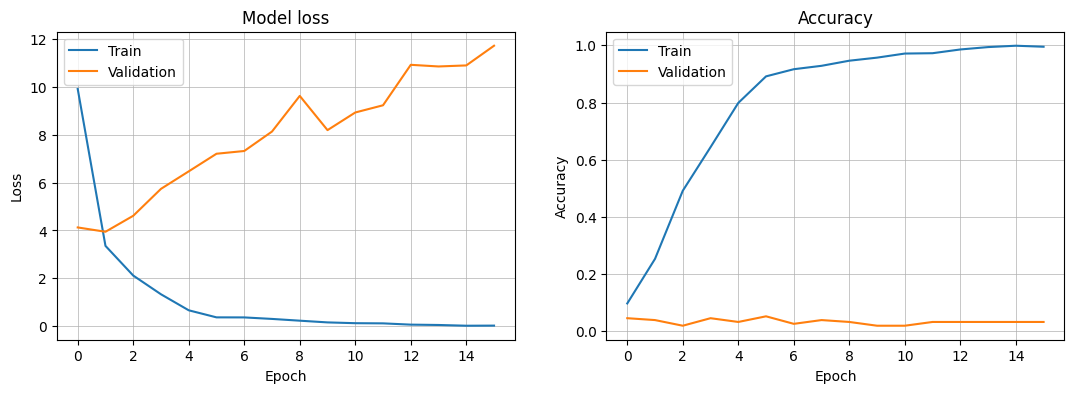

In [32]:
plot_history(history, metric='accuracy')

## Testing and submission

In [33]:
# Function to split audio file into chunks of given duration
def split_audio(path, duration, sr):
    sig, rate = librosa.load(path, sr=sr)
    chunk_size = duration * rate
    chunks = [sig[i:i+chunk_size] for i in range(0, len(sig), chunk_size)]
    return chunks

In [34]:
# This is where we will store our results
row_id_list = []
X_test = []

# Process audio files and make predictions with tqdm progress bar
for audio_file, file_number in tqdm(zip(test_file_list, test_number_list), total=len(test_file_list), desc='Processing test files'):
    path = os.path.join(TEST_AUDIO_DIR, audio_file)

    # Split audio file into 5-second chunks
    audio_chunks = split_audio(path, duration=5, sr=SAMPLE_RATE)

    for i, chunk in enumerate(audio_chunks):
        chunk = audio_chunks[i]
        chunk_end_time = (i + 1) * 5
        row_id = f"soundscape_{file_number}_{chunk_end_time}"
        row_id_list.append(row_id)

        features = extract_features(chunk)

        X_test.append(features)   

X_test = np.array(X_test) # convert list of 1D arrays to 2D array

Processing test files: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


In [40]:
# Select model used for predictions
best_model = model

In [41]:
y_pred_proba = best_model.predict(X_test)
results = proba_df(y_pred_proba)
results

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


,row_id,asbfly,ashdro1,ashpri1,ashwoo2,asikoe2,asiope1,aspfly1,aspswi1,barfly1,...,whbwoo2,whcbar1,whiter2,whrmun,whtkin2,woosan,wynlau1,yebbab1,yebbul3,zitcis1
0,soundscape_1000170626_5,0.0,0.0,0.0,0.0,0.0,0.0,0.000031,0.0,0.0,...,0.000287,0.0,0.002270,0.0,0.0,0.0,0.000078,0.0,0.0,0.0
1,soundscape_1000170626_10,0.0,0.0,0.0,0.0,0.0,0.0,0.000019,0.0,0.0,...,0.000195,0.0,0.001603,0.0,0.0,0.0,0.000052,0.0,0.0,0.0
2,soundscape_1000170626_15,0.0,0.0,0.0,0.0,0.0,0.0,0.000026,0.0,0.0,...,0.000287,0.0,0.002005,0.0,0.0,0.0,0.000076,0.0,0.0,0.0
3,soundscape_1000170626_20,0.0,0.0,0.0,0.0,0.0,0.0,0.000037,0.0,0.0,...,0.000375,0.0,0.002418,0.0,0.0,0.0,0.000085,0.0,0.0,0.0
4,soundscape_1000170626_25,0.0,0.0,0.0,0.0,0.0,0.0,0.000020,0.0,0.0,...,0.000225,0.0,0.001772,0.0,0.0,0.0,0.000058,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,soundscape_1000450112_220,0.0,0.0,0.0,0.0,0.0,0.0,0.000051,0.0,0.0,...,0.000494,0.0,0.002766,0.0,0.0,0.0,0.000134,0.0,0.0,0.0
236,soundscape_1000450112_225,0.0,0.0,0.0,0.0,0.0,0.0,0.000013,0.0,0.0,...,0.000124,0.0,0.001294,0.0,0.0,0.0,0.000032,0.0,0.0,0.0
237,soundscape_1000450112_230,0.0,0.0,0.0,0.0,0.0,0.0,0.000057,0.0,0.0,...,0.000583,0.0,0.003340,0.0,0.0,0.0,0.000160,0.0,0.0,0.0
238,soundscape_1000450112_235,0.0,0.0,0.0,0.0,0.0,0.0,0.000063,0.0,0.0,...,0.000618,0.0,0.003261,0.0,0.0,0.0,0.000156,0.0,0.0,0.0


In [42]:
# Convert our results to csv
results.to_csv("submission.csv", index=False)